In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'/home/ubuntu/varios/skforecast'

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDiff import ForecasterAutoregDiff
from skforecast.ForecasterAutoregDiff_2 import ForecasterAutoregDiff_2
from sklearn.linear_model import LinearRegression   
from sklearn.ensemble import RandomForestRegressor

Train dates : 1991-07-01 00:00:00 --- 2003-03-01 00:00:00  (n=141)
Test dates  : 2003-04-01 00:00:00 --- 2008-06-01 00:00:00  (n=63)


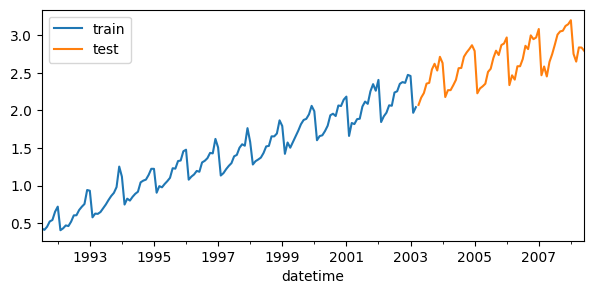

In [75]:

# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Add a smooth positive trend
# ==============================================================================
t = np.arange(len(data))
data = data + 0.01 * t

# Data partition train-test
# ==============================================================================
end_train = '2003-03-01 23:59:00'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

2003-04-01    2.171097
2003-05-01    2.250208
2003-06-01    2.310426
2003-07-01    2.329878
2003-08-01    2.378884
Freq: MS, Name: pred, dtype: float64

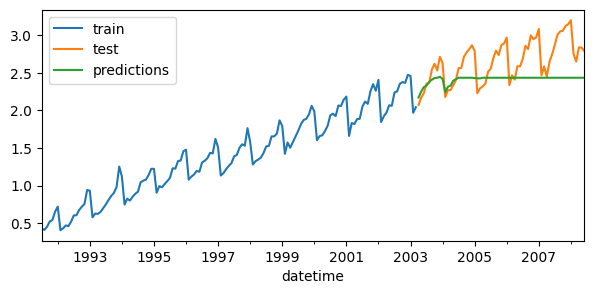

In [79]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(), #LinearRegression(),
                 lags      = 15
             )

forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
display(predictions.head())

2003-04-01    2.099816
2003-05-01    2.028245
2003-06-01    1.885413
2003-07-01    1.845612
2003-08-01    1.705676
Freq: MS, Name: pred, dtype: float64

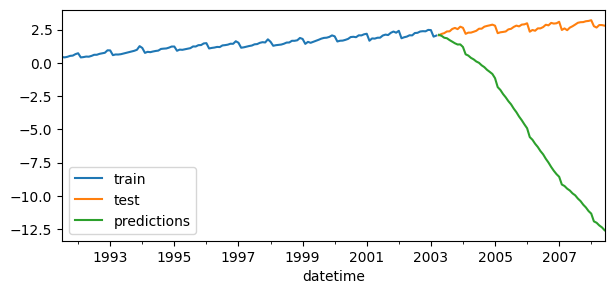

In [85]:
forecaster = ForecasterAutoregDiff_2(
                 regressor = RandomForestRegressor(random_state=12345678), #LinearRegression(),
                 lags      = 15,
                 differentiation=1
            )

forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
display(predictions.head())

2003-04-01     6.798996
2003-05-01     9.077016
2003-06-01    11.283774
2003-07-01    13.593563
2003-08-01    15.803218
Freq: MS, Name: pred, dtype: float64

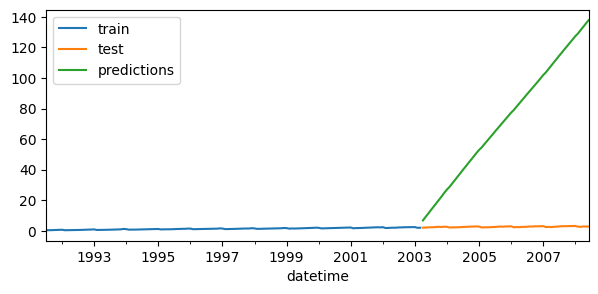

In [84]:
forecaster = ForecasterAutoregDiff(
                 regressor = RandomForestRegressor(random_state=12345678), #LinearRegression(),
                 lags      = 15,
                 differentiation=1
            )

forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
display(predictions.head())  

In [37]:
forecaster = ForecasterAutoregDiff(
    regressor = Ridge(),
    lags = 3,
    differentiation = 1,
)

X_train, y_train = forecaster.create_train_X_y(y=y, exog=exog)
display(X_train.head(3))
display(y_train.head(3))    

,lag_1,lag_2,lag_3,exog_1,exog_2,exog_3
datetime,,,,,,
1991-11-01,0.070188,0.041057,-0.019085,0.850287,-0.616841,-1.937903
1991-12-01,0.019630,0.070188,0.041057,1.090726,-0.533821,1.247253
1992-01-01,0.110087,0.019630,0.070188,-0.944706,-2.706674,-0.665652


datetime
1991-11-01    0.019630
1991-12-01    0.110087
1992-01-01    0.067271
Freq: MS, Name: y, dtype: float64

In [44]:
forecaster = ForecasterAutoreg(
    regressor = LinearRegression(),
    lags = 24,
)
forecaster.fit(y=y_train)
predictions = forecaster.predict(steps=12)



<Axes: xlabel='date'>

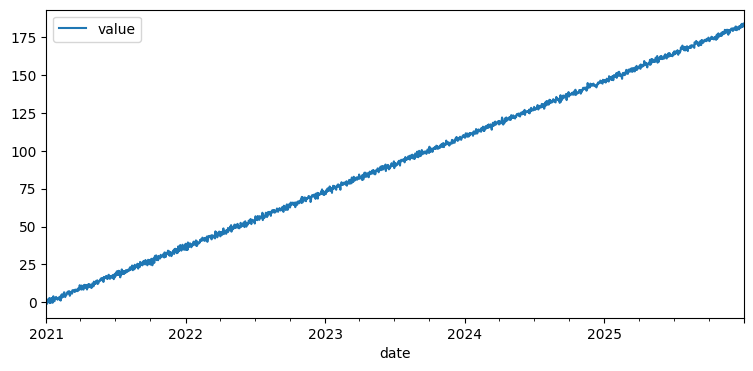

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Create a time series dataset with a trend and seasonality
dates = pd.date_range(start='2021-01-01', end='2025-12-31', freq='D')
values = np.arange(len(dates)) * 0.1 + np.random.normal(0, 1, len(dates))
df = pd.DataFrame({'date': dates, 'value': values})
df.set_index('date', inplace=True)

df.plot(figsize=(9, 4))

datetime
2005-07-01    0.874336
2005-08-01    1.006497
2005-09-01    1.094736
2005-10-01    1.027043
2005-11-01    1.149232
2005-12-01    1.160712
2006-01-01    1.230691
2006-02-01    0.587135
2006-03-01    0.706959
2006-04-01    0.639641
2006-05-01    0.807405
2006-06-01    0.797970
2006-07-01    0.884312
2006-08-01    1.049648
2006-09-01    0.995709
2006-10-01    1.168253
2006-11-01    1.108038
2006-12-01    1.120053
2007-01-01    1.223319
2007-02-01    0.597753
2007-03-01    0.704398
2007-04-01    0.561760
2007-05-01    0.745258
2007-06-01    0.837934
2007-07-01    0.954144
2007-08-01    1.078219
2007-09-01    1.110982
2007-10-01    1.109979
2007-11-01    1.163534
2007-12-01    1.176589
2008-01-01    1.219941
2008-02-01    0.761822
2008-03-01    0.649435
2008-04-01    0.827887
2008-05-01    0.816255
2008-06-01    0.762137
Freq: MS, Name: y, dtype: float64

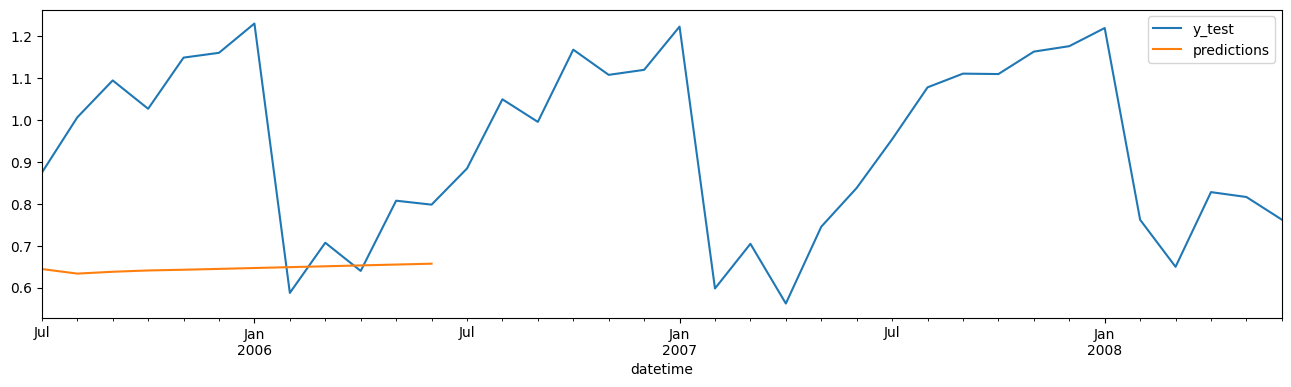

In [94]:
forecaster = ForecasterAutoregDiff(
    regressor = Ridge(),
    lags = 3,
    differentiation = 1,
)
forecaster.fit(y=y_train)
predictions = forecaster.predict(steps=12)
fig, axis = plt.subplots(figsize=(16, 4))
y_test.plot(ax=axis, label='y_test')
predictions.plot(ax=axis, label='predictions')
axis.legend();
y_test

<Axes: xlabel='datetime'>

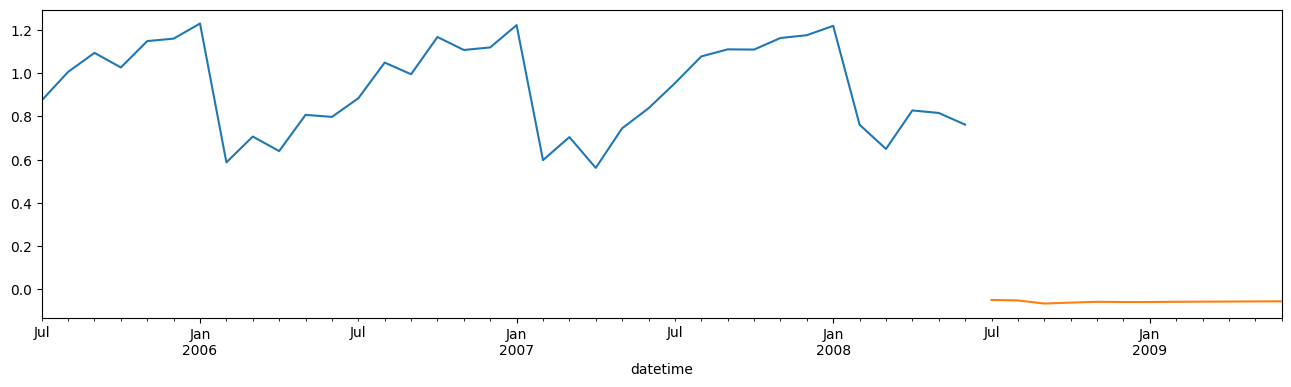

In [88]:
forecaster = ForecasterAutoregDiff_2(
    regressor = Ridge(),
    lags = 3,
    differentiation = 1,
)
forecaster.fit(y=y_train)
predictions = forecaster.predict(steps=12)
fig, axis = plt.subplots(figsize=(16, 4))
y_test.plot(ax=axis, label='y_test')
predictions.plot(ax=axis, label='predictions')

In [7]:
forecaster = ForecasterAutoregDiff(
    regressor = Ridge(),
    lags = 3,
    differentiation = None
)
forecaster.fit(y=y)
forecaster.predict(steps=5)

2000-04-10    0.034849
2000-04-11    0.227546
2000-04-12   -0.099882
2000-04-13    0.070084
2000-04-14    0.015421
Freq: D, Name: pred, dtype: float64

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class TimeSeriesDifferentiator(BaseEstimator, TransformerMixin):
    """
    Transforms a time series into a differentiated time series of order n.
    It also reverts the differentiation.

    Parameters
    ----------
    order : int
        Order of differentiation.

    Attributes
    ----------
    initial_values : list
        List with the initial value the time series after each differentiation.
        This is used to revert the differentiation.
    order : int
        Order of differentiation.   

    """
    
    def __init__(self, order=1):

        self.order = order
        self.initial_values = []
    

    def fit(self, X, y: Any=None):
        """
        Fits the transformer. This method does nothing.

        Parameters
        ----------
        X : array-like of shape (n_samples,)
            Time series to be differentiated.
        y : None
            Ignored.

        Returns
        -------
        self : object
        
        """

        self.initial_values = []

        return self
    

    def transform(self, X, y: Any=None):
        """
        Transforms a time series into a differentiated time series of order n.

        Parameters
        ----------
        X : array-like of shape (n_samples,)
            Time series to be differentiated.
        y : None
            Ignored.
        
        Returns
        -------
        X_diff : array-like of shape (n_samples,)
            Differentiated time series.

        """

        for i in range(self.order):
            if i == 0:
                self.initial_values.append(X[0])
                X_diff = np.diff(X, n=1)
            else:
                self.initial_values.append(X_diff[0])
                X_diff = np.diff(X_diff, n=1)
                
        X_diff = np.append((np.full(shape=self.order, fill_value=np.nan)), X_diff)

        return X_diff
    
    
    def inverse_transform(self, X, y: Any=None):
        """
        Reverts the differentiation.

        Parameters
        ----------
        X : array-like of shape (n_samples,)
            Differentiated time series.
        y : None
            Ignored.
        
        Returns
        -------
        X_diff : array-like of shape (n_samples,)
            Reverted differentiated time series.

        """

        # Remove initial nan values if present
        X = X[np.argmax(~np.isnan(X)):]
        print("Initial values:", self.initial_values)
        for i in range(self.order):
            if i == 0:
                X_diff = np.insert(X, 0, self.initial_values[self.order-1])
                X_diff = np.cumsum(X_diff, dtype=float)
            else:
                X_diff = np.insert(X_diff, 0, self.initial_values[self.order-i-1])
                X_diff = np.cumsum(X_diff, dtype=float)

        return X_diff



# Generate a sample time series
X = np.arange(10)
X = np.random.randint(0, 10, 10)

# Differentiate the time series up to order 1
differentiator = TimeSeriesDifferentiator(order=4)
differentiator.fit(X)
X_diff = differentiator.transform(X)



# Revert the differentiation
X_reverted = differentiator.inverse_transform(X_diff)

# Print the original time series, the differentiated time series, and the reverted time series
print(f"Original time series: {X}")
print(f"Differentiated time series: {X_diff}")
print(f"Reverted time series: {X_reverted}")

Tr 1: [ 2 -5  2  4 -4  2  0  2 -3]
Tr 2: [-7  7  2 -8  6 -2  2 -5]
Tr 2: [ 14  -5 -10  14  -8   4  -7]
Tr 2: [-19  -5  24 -22  12 -11]
Initial values: [3, 2, -7, 14]
1 iTr: [ 14. -19.  -5.  24. -22.  12. -11.]
1 iTr: [ 14.  -5. -10.  14.  -8.   4.  -7.]
2 iTr: [ -7.  14.  -5. -10.  14.  -8.   4.  -7.]
2 iTr: [-7.  7.  2. -8.  6. -2.  2. -5.]
2 iTr: [ 2. -7.  7.  2. -8.  6. -2.  2. -5.]
2 iTr: [ 2. -5.  2.  4. -4.  2.  0.  2. -3.]
2 iTr: [ 3.  2. -5.  2.  4. -4.  2.  0.  2. -3.]
2 iTr: [3. 5. 0. 2. 6. 2. 4. 4. 6. 3.]
Original time series: [3 5 0 2 6 2 4 4 6 3]
Differentiated time series: [ nan  nan  nan  nan -19.  -5.  24. -22.  12. -11.]
Reverted time series: [3. 5. 0. 2. 6. 2. 4. 4. 6. 3.]


In [37]:
differentiator.fit_transform(X)

array([nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [3]:
np.random.seed(123)
y_values = np.random.randint(0, 10, 10)
y_values

array([2, 2, 6, 1, 3, 9, 6, 1, 0, 1])

In [7]:
diff = 2

y_diff = np.diff(
    a = y_values,
    n = diff
)
y_diff

array([ 4, -9,  7,  4, -9, -2,  4,  2])

In [8]:
y_inverse = np.insert(y_diff, 0, y_values[1])
y_inverse = np.cumsum(y_inverse)
y_inverse

array([ 2,  6, -3,  4,  8, -1, -3,  1,  3])

In [9]:
y_inverse = np.insert(y_inverse, 0, y_values[0])
y_inverse = np.cumsum(y_inverse)
y_inverse

array([ 2,  4, 10,  7, 11, 19, 18, 15, 16, 19])

In [ ]:
X_diff = np.insert(X_diff, 0, np.full(shape=self.order, fill_value=np.nan))

In [19]:
%%timeit -r 4 -n 1000

np.full(shape=2, fill_value=np.nan)

2.31 µs ± 621 ns per loop (mean ± std. dev. of 4 runs, 1,000 loops each)


In [21]:
%%timeit -r 4 -n 1000

np.repeat(np.nan, 2)

3.24 µs ± 322 ns per loop (mean ± std. dev. of 4 runs, 1,000 loops each)


In [20]:
%%timeit -r 4 -n 1000

np.zeros(2) + np.nan

1.09 µs ± 105 ns per loop (mean ± std. dev. of 4 runs, 1,000 loops each)


In [22]:
aa = np.arange(10)

In [26]:
np.append((np.full(shape=2, fill_value=np.nan)), aa)

array([nan, nan,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [ ]:
%%timeit -r 4 -n 1000

np.append((np.full(shape=self.order, fill_value=np.nan)), aa)